# Adiabatic Quantum Computing

We will make a simple example so that the formalism of this algorithm is clear to everyone.

We will need for this exercise:

* An Initial Hamiltonian and its ground state (so it should be easy or known)
* A final Hamiltonian (the problem we are trying to solve)
* A Scheduling function that governs the evolution and mixture between the two

So let's start by selecting our Initial Hamiltonian:

$$

H_{init} = - \sum_i^N \sigma_i^x

$$

In [1]:
N = 3 # 3 qubit system

In [2]:
import numpy as np

# \sigma_x
sigma_x = np.matrix([[0, 1],
                     [1, 0]])

# Initial hamiltonian
H_init = 0
for j in range(N):
    H_init += -1.0 * np.kron( np.kron(np.identity(2**j), sigma_x), np.identity(2**(N-j-1)) )

H_init

matrix([[ 0., -1., -1.,  0., -1.,  0.,  0.,  0.],
        [-1.,  0.,  0., -1.,  0., -1.,  0.,  0.],
        [-1.,  0.,  0., -1.,  0.,  0., -1.,  0.],
        [ 0., -1., -1.,  0.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.,  0., -1., -1.,  0.],
        [ 0., -1.,  0.,  0., -1.,  0.,  0., -1.],
        [ 0.,  0., -1.,  0., -1.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.,  0., -1., -1.,  0.]])

In [3]:
from math import sqrt
from numpy.linalg import eig

# Get eigen spectrum for a particular hamiltonian
def get_eigenspectra(h_mat):
    """
    Computes the eigenspectra
    """
    evals, evecs = eig(h_mat)
    sort_index = np.argsort(evals)

    return evals [sort_index], evecs[:, sort_index]

# Gets the ground state
def get_gs(h_mat):
    """ Computes the ground state """
    evals, evecs = eig(h_mat)
    sort_index = np.argsort(evals)

    stat_gs = evecs[:, sort_index[0]]
    gs_val = evals[sort_index[0]]
    
    num = 1
    for idx in sort_index[1:]:
        if evals[idx] == gs_val:
            stat_gs += evecs[:, idx]
            num += 1
        else:
            break

    return np.dot((1/sqrt(num)), stat_gs)


In [4]:
get_gs(H_init)

matrix([[-0.35355339],
        [-0.35355339],
        [-0.35355339],
        [-0.35355339],
        [-0.35355339],
        [-0.35355339],
        [-0.35355339],
        [-0.35355339]])

Now for our target Hamiltonian we will select a random instance of the Ising model that looks like:

$$

H_{problem} = \sum_j^N J_{j,j+1}\sigma_j^z\sigma_{j+1}^z 

$$

In [5]:
J = -1

sigma_z = np.matrix([[1, 0],
                     [0, -1]])

H_problem = 0
for i in range(N-1):
    H_problem = J* np.kron( np.kron(np.identity(2**i), sigma_z), np.identity(2**(N-i-1)) ) * np.kron( np.kron(np.identity(2**(i+1)), sigma_z), np.identity(2**(N-(i+1)-1)) )

H_problem

matrix([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

In [6]:
get_gs(H_problem)

matrix([[0.5],
        [0. ],
        [0. ],
        [0.5],
        [0.5],
        [0. ],
        [0. ],
        [0.5]])

We can see our Ising model's ground ground state (minimum energy eigenstate) is

$$

|\psi\rangle = \frac{1}{2}(|000\rangle + |011\rangle + |100\rangle + |111\rangle).

$$

Now we would only need to define a scheduling function to mix both Hamiltonians. Just for simplicity we will use a single scheduling function $\lambda(t)$ and use its complementary for the decaying of the initial Hamiltonian.

$$

H(t) = (1-\lambda(t))H_{init} + \lambda(t)H_{problem}

$$



In [7]:
e0 = []
e1 = []

# Now perform a mixing schedule
time_range = np.arange(0.0, 1.0, 0.1)
for lambda_t in time_range:

    # Time dependent Hamiltonian
    H = (1-lambda_t)*H_init + lambda_t*H_problem

    # Get eigenspectra
    vals, stats = get_eigenspectra(H)
    e0.append(vals[0])
    e1.append(vals[1])

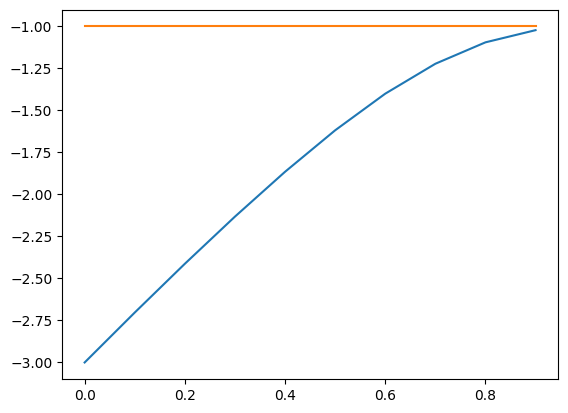

In [8]:
import matplotlib.pyplot as plt

plt.plot(time_range, e0, time_range, e1)
plt.show()

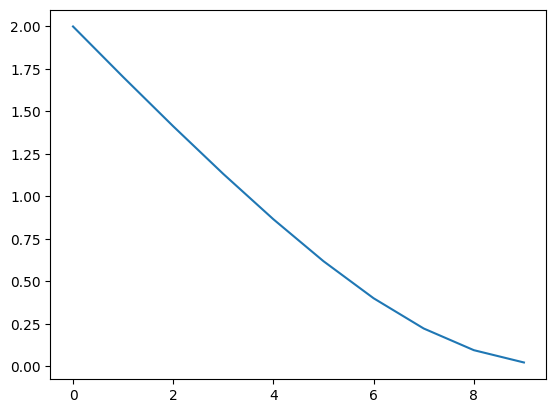

In [9]:
plt.plot(np.subtract(e1,e0))
plt.show()

In [10]:
stats[:, 0]

matrix([[0.49701447],
        [0.05455839],
        [0.05455839],
        [0.49701447],
        [0.49701447],
        [0.05455839],
        [0.05455839],
        [0.49701447]])

Once again, we don't need to do everything from scratch. Libraries like Qutip allow us to benefit from the existing work.

# Qutip

In [11]:
from qutip import qeye, sigmaz, sigmax, tensor

# Create a particular instance
J = -1

# Matrices to compose the hamiltonian
i = qeye(2)
z = sigmaz()

# Ising model
h_ising = J * tensor(i,z,z)

# Init state
x = sigmax()
h_b = -1 * tensor(x,i,i) + -1 * tensor(i,i,x) + -1 * tensor(i,x,i)

In [12]:
h_b

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0. -1. -1.  0. -1.  0.  0.  0.]
 [-1.  0.  0. -1.  0. -1.  0.  0.]
 [-1.  0.  0. -1.  0.  0. -1.  0.]
 [ 0. -1. -1.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0. -1. -1.  0.]
 [ 0. -1.  0.  0. -1.  0.  0. -1.]
 [ 0.  0. -1.  0. -1.  0.  0. -1.]
 [ 0.  0.  0. -1.  0. -1. -1.  0.]]

In [13]:
h_ising

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]

In [14]:
from qutip import QobjEvo

def schedule(t, taumax):
    """
    Scheduling function for the adiabatic evolution
    """

    return t/taumax

# Tau max
taumax = 5.0

# The time dependent function
h_t = QobjEvo([[h_b, lambda t: 1 - schedule(t, taumax)],
        [h_ising, lambda t: schedule(t, taumax)]])

In [15]:
h_t(1.0)

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-0.2 -0.8 -0.8  0.  -0.8  0.   0.   0. ]
 [-0.8  0.2  0.  -0.8  0.  -0.8  0.   0. ]
 [-0.8  0.   0.2 -0.8  0.   0.  -0.8  0. ]
 [ 0.  -0.8 -0.8 -0.2  0.   0.   0.  -0.8]
 [-0.8  0.   0.   0.  -0.2 -0.8 -0.8  0. ]
 [ 0.  -0.8  0.   0.  -0.8  0.2  0.  -0.8]
 [ 0.   0.  -0.8  0.  -0.8  0.   0.2 -0.8]
 [ 0.   0.   0.  -0.8  0.  -0.8 -0.8 -0.2]]

In [16]:
eigvals, eigstates = h_t(0).eigenstates()
eigvals

array([-3., -1., -1., -1.,  1.,  1.,  1.,  3.])

In [17]:
psi0 = eigstates[0]
psi0

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[-0.35355339]
 [-0.35355339]
 [-0.35355339]
 [-0.35355339]
 [-0.35355339]
 [-0.35355339]
 [-0.35355339]
 [-0.35355339]]

In [18]:
h_t(taumax)

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]

In [19]:
eigvals, eigstates = h_t(taumax).eigenstates()
print(eigvals)

[-1. -1. -1. -1.  1.  1.  1.  1.]


In [20]:
0.5*(eigstates[0] + eigstates[1] + eigstates[2] + eigstates[3])

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.5]
 [0. ]
 [0. ]
 [0.5]
 [0.5]
 [0. ]
 [0. ]
 [0.5]]

In [21]:
from qutip import mesolve

taulist = np.linspace(0, taumax, 100)

evals_mat = np.zeros((len(taulist), 2**N))
idx = [0]
min_gap = [+np.inf]

def process_rho(tau, psi):
    """Process in between to
    obtain the eigenvalues

    Args:
        tau (float): Time step
        psi (Qobj): Psi
    """
    evals, _ = h_t(tau).eigenstates()
    evals_mat[idx[0],:] = np.real(evals)
    
    idx[0] += 1
    min_gap[0] = min(min_gap[0], evals[1]-evals[0])

# Solve the master equation
result = mesolve(h_t, psi0, taulist, c_ops=[], e_ops=process_rho, options={"store_states" : True})

In [22]:
result.final_state

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.4026931 -0.28765221j]
 [-0.05965692-0.03918574j]
 [-0.05965692-0.03918574j]
 [ 0.4026931 -0.28765221j]
 [ 0.4026931 -0.28765221j]
 [-0.05965692-0.03918574j]
 [-0.05965692-0.03918574j]
 [ 0.4026931 -0.28765221j]]

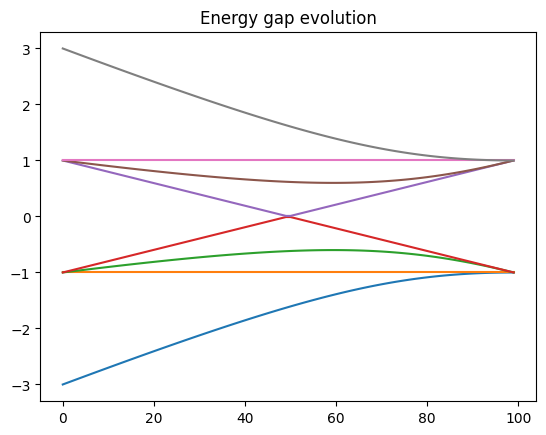

Found minimum gap: 0.0


In [23]:
# Plot results
plt.plot(evals_mat)
plt.title('Energy gap evolution')
plt.show()

print(f"Found minimum gap: {min_gap[0]}")

## Exercise

Can you think of a better scheduling function?

In [ ]:
# Your code goes here